In [1]:
from data_handling import get_data
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import faiss
from os.path import exists

# Data

In [2]:
data = get_data()
data.head()

,abstract,title,url
0,A fully differential calculation in perturba...,Calculation of prompt diphoton production cros...,https://arxiv.org/abs/0704.0001
1,"We describe a new algorithm, the $(k,\ell)$-...",Sparsity-certifying Graph Decompositions,https://arxiv.org/abs/0704.0002
2,The evolution of Earth-Moon system is descri...,The evolution of the Earth-Moon system based o...,https://arxiv.org/abs/0704.0003
3,We show that a determinant of Stirling cycle...,A determinant of Stirling cycle numbers counts...,https://arxiv.org/abs/0704.0004
4,In this paper we show how to compute the $\L...,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,https://arxiv.org/abs/0704.0005


In [3]:
data['text'] = data['title'] + " " + data['abstract']

# Model

In [4]:
model = SentenceTransformer('all-mpnet-base-v2', device='cuda')
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

#### Max Sequence Length

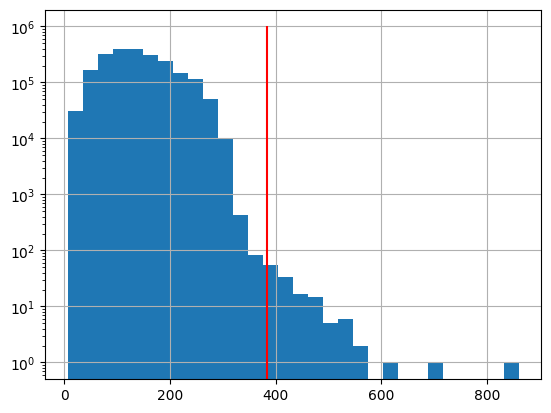

In [5]:
# Count number of words in text column
data['text'].apply(lambda x: len(x.split(' '))).hist(bins=30)
plt.yscale('log')
plt.vlines(384, 0, 10**6, colors='red')

# Faiss

In [6]:
model.encode(data['text'].values[0]).shape

(768,)

In [7]:
class FaissIdx:
    def __init__(self, model, dim=768):
        # Maintaining the document data
        # self.doc_map = dict()
        self.model = model

        # Initialize the index
        self.index = faiss.IndexFlatIP(dim)

        # Use GPU
        res = faiss.StandardGpuResources()
        self.index = faiss.index_cpu_to_gpu(res, 0, self.index)

    def add_doc(self, document_text):
        batch_size = 1024

        for i in tqdm(range(0, len(document_text), batch_size), desc="Adding documents to index", unit="batch"):
            self.index.add(self.model.encode(document_text[i:i+batch_size]))

        #self.doc_map[self.ctr] = document_text # store the original document text

        #def search_doc(self, query, k=3):
        #    D, I = self.index.search(self.model.encode(query).reshape(1, -1), k)
        #    return [{self.doc_map[idx]: score} for idx, score in zip(I[0], D[0]) if idx in self.doc_map]

    def load_index(self, index_path):
        self.index = faiss.read_index(index_path)
        self.ctr = self.index.ntotal
    
index = FaissIdx(model)

In [8]:
# If index exists, load it
if exists('faiss_index.faiss'):
    print("Loading index...")
    index.load_index('index.faiss')

#### Add to index

In [9]:
index.add_doc(data['text'].values)

Adding documents to index:   0%|          | 0/2140 [00:00<?, ?batch/s]

In [ ]:
# Save the index
faiss.write_index(index.index, "faiss_index.bin")